# Predicting best conversion timing

## Loading libraries

In [ ]:
import numpy as np
import pandas as pd

## Simulating data

In [ ]:
np.random.seed(42)

n = 50_000
df = pd.DataFrame({
    "timestamp": pd.to_datetime("2024-01-01")
                  + pd.to_timedelta(np.random.randint(0, 365*24, n), unit="h")
})

df["hour"] = df["timestamp"].dt.hour
df["weekday"] = df["timestamp"].dt.weekday
df["is_weekend"] = df["weekday"].isin([5,6]).astype(int)
df.head()

,timestamp,hour,weekday,is_weekend
0,2024-10-29 22:00:00,22,1,0
1,2024-02-05 20:00:00,20,0,0
2,2024-08-12 14:00:00,14,0,0
3,2024-08-04 07:00:00,7,6,1
4,2024-08-26 22:00:00,22,0,0


In [20]:
base_cr = 0.03
hour_effect = df["hour"].between(18, 22).astype(int) * 0.02
weekday_effect = df["weekday"].between(1, 4).astype(int) * 0.01

df["conversion_prob"] = base_cr + hour_effect + weekday_effect
df["converted"] = np.random.binomial(1, df["conversion_prob"])
df.head()

,timestamp,hour,weekday,is_weekend,conversion_prob,converted
0,2024-10-29 22:00:00,22,1,0,0.06,0
1,2024-02-05 20:00:00,20,0,0,0.05,0
2,2024-08-12 14:00:00,14,0,0,0.03,0
3,2024-08-04 07:00:00,7,6,1,0.03,0
4,2024-08-26 22:00:00,22,0,0,0.05,0


In [21]:
agg = (
    df.groupby(["weekday", "hour"])
      .agg(
          sessions=("converted", "count"),
          conversions=("converted", "sum")
      )
      .reset_index()
)

agg["conversion_rate"] = agg["conversions"] / agg["sessions"]
agg

,weekday,hour,sessions,conversions,conversion_rate
0,0,0,289,11,0.038062
1,0,1,294,6,0.020408
2,0,2,291,9,0.030928
3,0,3,283,12,0.042403
4,0,4,307,14,0.045603
...,...,...,...,...,...
163,6,19,272,10,0.036765
164,6,20,277,11,0.039711
165,6,21,279,15,0.053763
166,6,22,275,12,0.043636


In [24]:
agg["hour_sin"] = np.sin(2 * np.pi * agg["hour"] / 24)
agg["hour_cos"] = np.cos(2 * np.pi * agg["hour"] / 24)

agg["weekday_sin"] = np.sin(2 * np.pi * agg["weekday"] / 7)
agg["weekday_cos"] = np.cos(2 * np.pi * agg["weekday"] / 7)
agg.head()

,weekday,hour,sessions,conversions,conversion_rate,hour_sin,hour_cos,weekday_sin,weekday_cos
0,0,0,289,11,0.038062,0.000000,1.000000,0.0,1.0
1,0,1,294,6,0.020408,0.258819,0.965926,0.0,1.0
2,0,2,291,9,0.030928,0.500000,0.866025,0.0,1.0
3,0,3,283,12,0.042403,0.707107,0.707107,0.0,1.0
4,0,4,307,14,0.045603,0.866025,0.500000,0.0,1.0


## Creating model

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

features = [
    "hour", "weekday",
    "hour_sin", "hour_cos",
    "weekday_sin", "weekday_cos",
    "sessions"
]

X = agg[features]
y = agg["conversion_rate"]

model = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=3,
    random_state=42
)

model.fit(X, y)

print("MAE:", mean_absolute_error(y, model.predict(X)))

MAE: 0.006493048142610746


In [26]:
grid = pd.DataFrame([
    {"weekday": d, "hour": h}
    for d in range(7)
    for h in range(24)
])

grid["is_weekend"] = grid["weekday"].isin([5,6]).astype(int)

grid["hour_sin"] = np.sin(2 * np.pi * grid["hour"] / 24)
grid["hour_cos"] = np.cos(2 * np.pi * grid["hour"] / 24)
grid["weekday_sin"] = np.sin(2 * np.pi * grid["weekday"] / 7)
grid["weekday_cos"] = np.cos(2 * np.pi * grid["weekday"] / 7)

# Expected volume (use historical average)
grid["sessions"] = agg["sessions"].mean()

grid["predicted_cr"] = model.predict(grid[features])

grid.sort_values("predicted_cr", ascending=False).head(5)
grid

,weekday,hour,is_weekend,hour_sin,hour_cos,weekday_sin,weekday_cos,sessions,predicted_cr
0,0,0,0,0.000000,1.000000,0.000000,1.00000,297.619048,0.029232
1,0,1,0,0.258819,0.965926,0.000000,1.00000,297.619048,0.030399
2,0,2,0,0.500000,0.866025,0.000000,1.00000,297.619048,0.032906
3,0,3,0,0.707107,0.707107,0.000000,1.00000,297.619048,0.033659
4,0,4,0,0.866025,0.500000,0.000000,1.00000,297.619048,0.034224
...,...,...,...,...,...,...,...,...,...
163,6,19,1,-0.965926,0.258819,-0.781831,0.62349,297.619048,0.044609
164,6,20,1,-0.866025,0.500000,-0.781831,0.62349,297.619048,0.044901
165,6,21,1,-0.707107,0.707107,-0.781831,0.62349,297.619048,0.045906
166,6,22,1,-0.500000,0.866025,-0.781831,0.62349,297.619048,0.043925


## Plotting model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

heatmap = (
    grid
    .pivot(index="weekday", columns="hour", values="predicted_cr")
    .sort_index()
)

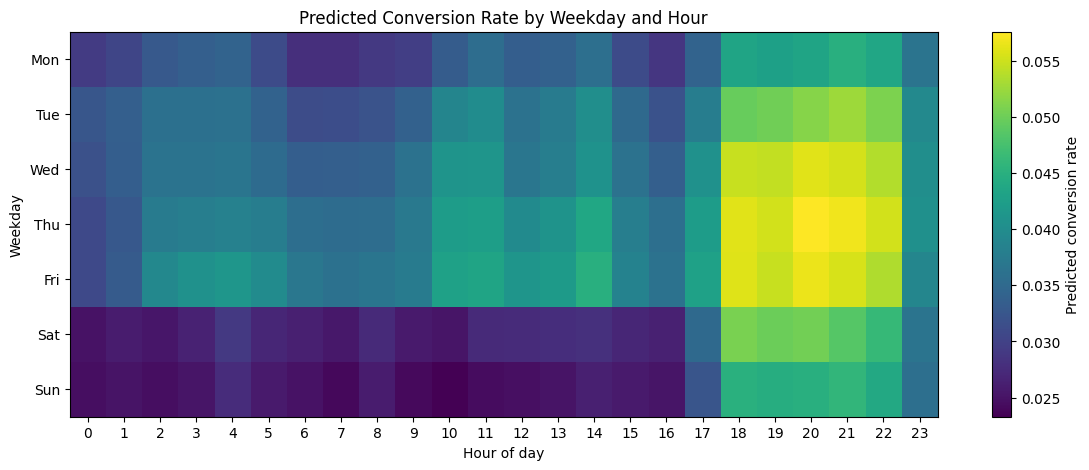

In [ ]:
plt.figure(figsize=(14, 5))
plt.imshow(heatmap, aspect="auto")
plt.colorbar(label="Predicted conversion rate")

plt.xticks(range(24), range(24))
plt.yticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])

plt.xlabel("Hour of day")
plt.ylabel("Weekday")
plt.title("Predicted Conversion Rate by Weekday and Hour")

plt.show()

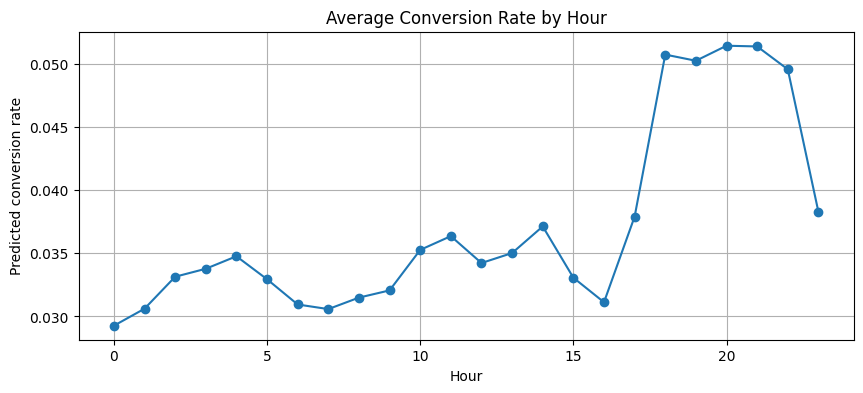

In [29]:
hour_curve = (
    grid
    .groupby("hour")["predicted_cr"]
    .mean()
)

plt.figure(figsize=(10, 4))
plt.plot(hour_curve.index, hour_curve.values, marker="o")
plt.xlabel("Hour")
plt.ylabel("Predicted conversion rate")
plt.title("Average Conversion Rate by Hour")
plt.grid(True)
plt.show()


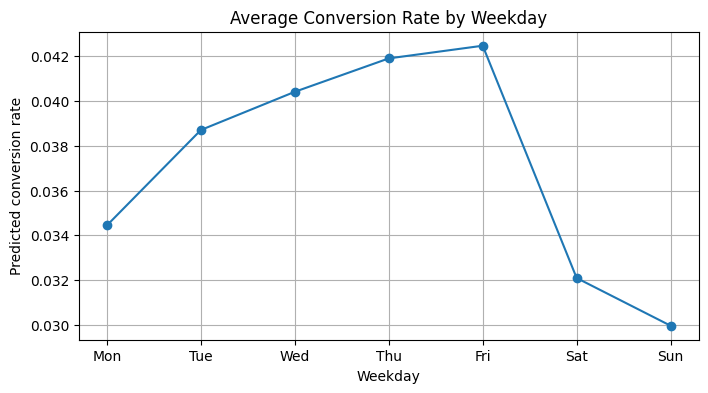

In [30]:
weekday_curve = (
    grid
    .groupby("weekday")["predicted_cr"]
    .mean()
)

plt.figure(figsize=(8, 4))
plt.plot(
    ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"],
    weekday_curve.values,
    marker="o"
)
plt.xlabel("Weekday")
plt.ylabel("Predicted conversion rate")
plt.title("Average Conversion Rate by Weekday")
plt.grid(True)
plt.show()


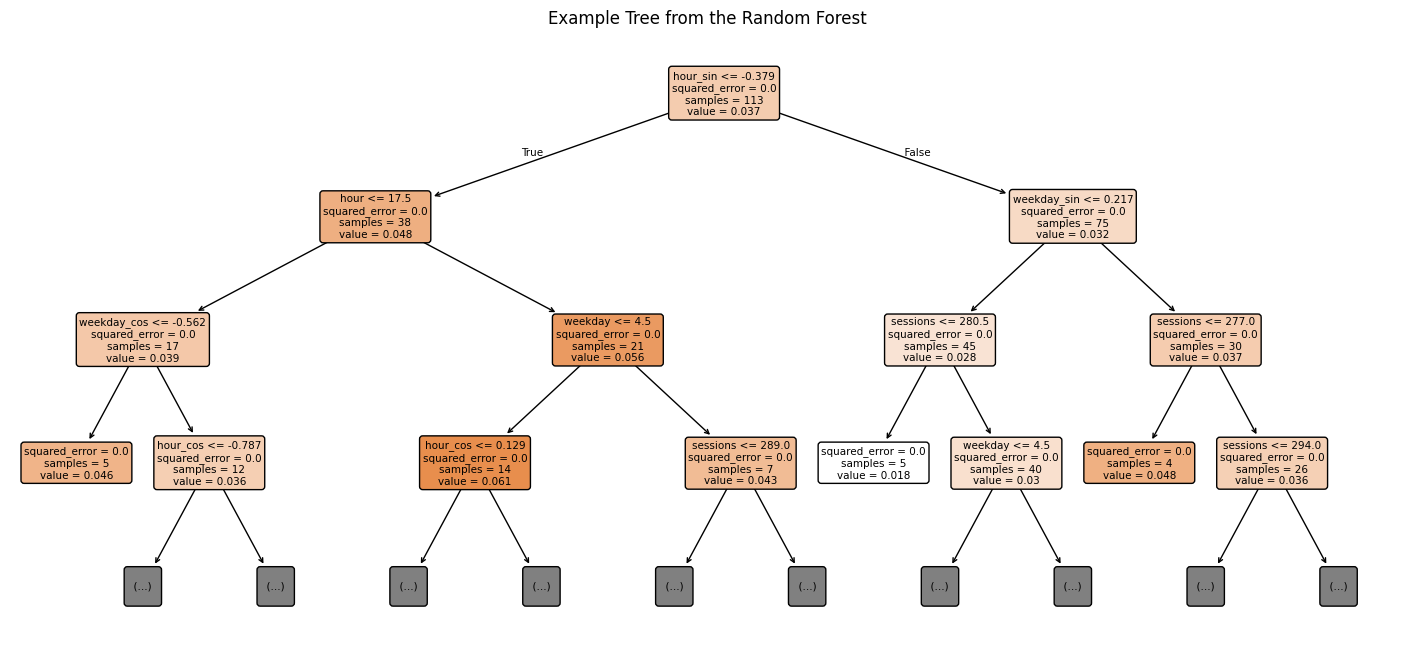

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plot_tree(
    model.estimators_[0],   # one tree
    feature_names=features,
    filled=True,
    max_depth=3,
    rounded=True
)

plt.title("Example Tree from the Random Forest")
plt.show()

## Partial dependency - hour effect

/Users/mbp249/anaconda3/envs/maia/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


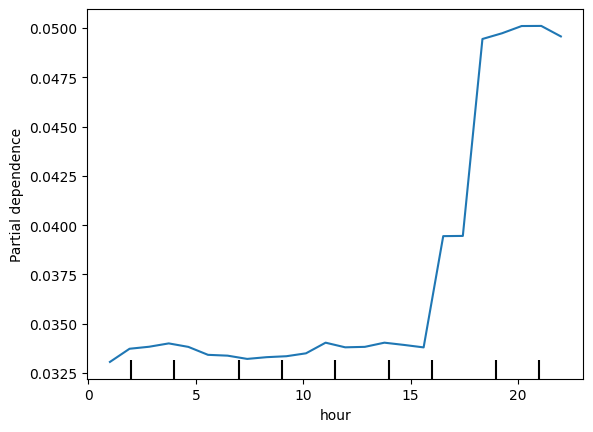

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    model,
    X,
    features=["hour"],
    grid_resolution=24
)
plt.show()

## Partial dependency - weekday effect

/Users/mbp249/anaconda3/envs/maia/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


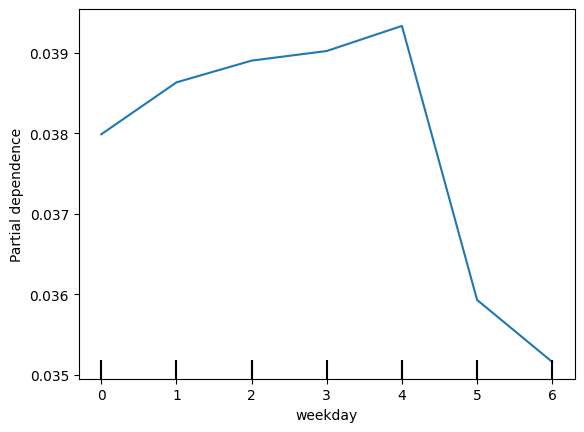

In [ ]:
PartialDependenceDisplay.from_estimator(
    model,
    X,
    features=["weekday"],
    grid_resolution=7
)
plt.show()

## Partial dependency hour x weekeday interaction

/Users/mbp249/anaconda3/envs/maia/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


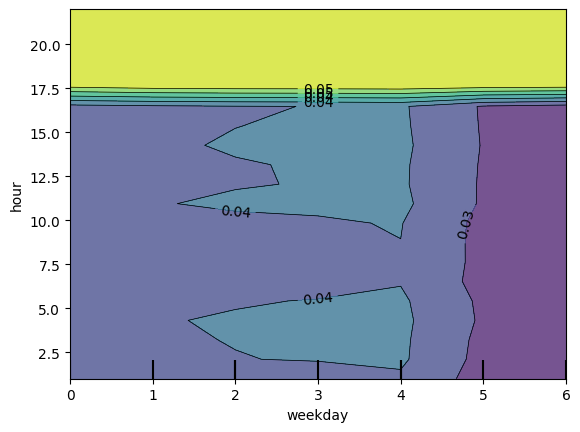

In [ ]:
PartialDependenceDisplay.from_estimator(
    model,
    X,
    features=[("weekday", "hour")],
    grid_resolution=20
)
plt.show()

## ICE plots (individual conditional expectation)

/Users/mbp249/anaconda3/envs/maia/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


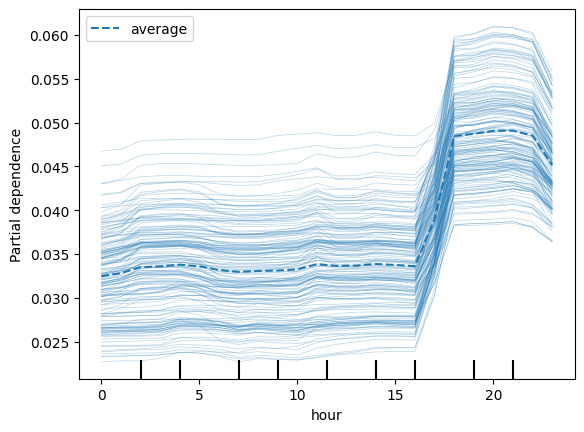

In [ ]:
PartialDependenceDisplay.from_estimator(
    model,
    X,
    features=["hour"],
    kind="both"   # PDP + ICE
)
plt.show()